In [20]:
import torch    
import json 
from ptlpinns.models import model, transfer
from ptlpinns.perturbation import LPM, standard
from ptlpinns.odes import forcing, numerical, equations
import numpy as np
import matplotlib.pyplot as plt
import math

### Load models

In [21]:
name_undamped = "undamped_k12"

undamped_path = f"/home/dda24/PTL-PINNs/ptlpinns/models/train/{name_undamped}"
undamped_name = f"model_{name_undamped}.pth"
undamped_model, training_log = model.load_model(undamped_path, undamped_name)

12 True True True 1.0 16 [256, 256, 512]


In [22]:
name_underdamped = "underdamped_k12"

underdamped_path = f"/home/dda24/PTL-PINNs/ptlpinns/models/train/{name_underdamped}"
underdamped_name = f"model_{name_underdamped}.pth"
underdamped_model, training_log = model.load_model(underdamped_path, underdamped_name)

12 True True True 1.0 16 [128, 128, 256]


In [23]:
name_overdamped = "overdamped_k15"

overdamped_path = f"/home/dda24/PTL-PINNs/ptlpinns/models/train/{name_overdamped}"
overdamped_name = f"model_{name_overdamped}.pth"
overdamped_model, training_log = model.load_model(overdamped_path, overdamped_name)

15 True True False [128, 128, 256]


### Problem definition

In [24]:
N = 5120
t_span = (0, 15)
t_eval = np.linspace(t_span[0], t_span[1], N)

w_list_transfer = [1]
ic_list = [[1, 0]]
epsilon_list = [0.5]
p_list = [6]
q = [(3, -1), (5, 1)]

### Compute latent representations

In [25]:
H_dict_undamped = transfer.compute_H_dict(undamped_model, N=N, bias=True, t_span=t_span)
H_dict_overdamped = transfer.compute_H_dict(overdamped_model, N=N, bias=True, t_span=t_span)
H_dict_underdamped = transfer.compute_H_dict(underdamped_model, N=N, bias=True, t_span=t_span)

### General transfer parameters

In [26]:
def my_forcing(numpy=False):
    if not numpy:
        def force(t):
            return torch.stack((torch.zeros_like(t), torch.cos(t)), dim=1)
    else:
        def force(t):
            return np.stack((np.zeros_like(t), np.cos(t)), axis=1)
    return force

forcing_list_underdamped, forcing_overdamped_list = [my_forcing(True)], [my_forcing(True)]
forcing_undamped_list = [forcing.zeroes_2D(numpy=True)]
zeta_list_underdamped = [0.5]
zeta_list_overdamped = [5]
zeta_list_undamped = [0]

### Numerical solver

In [27]:
# here we hardcode the forcing functions

ode_undamped = equations.ode_oscillator_1D(w_0=w_list_transfer[0], zeta=0, forcing_1D=lambda t: np.zeros_like(t), q=q, epsilon=epsilon_list[0])
numerical_undamped_duffing = numerical.solve_ode_equation(ode_undamped, (t_eval[0], t_eval[-1]), t_eval, ic_list[0])

ode_underdamped = equations.ode_oscillator_1D(w_0=w_list_transfer[0], zeta=zeta_list_underdamped[0], forcing_1D=lambda t: np.cos(t), q=q, epsilon=epsilon_list[0])
numerical_underdamped_duffing = numerical.solve_ode_equation(ode_undamped, (t_eval[0], t_eval[-1]), t_eval, ic_list[0])

ode_overdamped = equations.ode_oscillator_1D(w_0=w_list_transfer[0], zeta=zeta_list_overdamped[0], forcing_1D=lambda t: np.cos(t), q=q, epsilon=epsilon_list[0])
numerical_overdamped_duffing = numerical.solve_ode_equation(ode_undamped, (t_eval[0], t_eval[-1]), t_eval, ic_list[0])

### PTL-PINN solution

In [28]:
# solve underdamped oscillator with PTL-PINNs

NN_TL_solution_standard_underdamped, perturbation_solution_standard_underdamped, _ = transfer.compute_perturbation_solution(w_list_transfer, zeta_list_underdamped, epsilon_list, p_list, ic_list, forcing_list_underdamped, H_dict_underdamped, t_eval, training_log, all_p=True, comp_time=False, solver="standard", power=q)
NN_TL_solution_standard_underdamped = NN_TL_solution_standard_underdamped.squeeze()

PINN_x_solution_standard_underdamped = [perturbation_solution_standard_underdamped[i][:, 0] for i in range(len(perturbation_solution_standard_underdamped))]
PINN_x_solution_series_standard_underdamped = standard.calculate_general_series(PINN_x_solution_standard_underdamped, epsilon=epsilon_list[0])

### Plot comparison

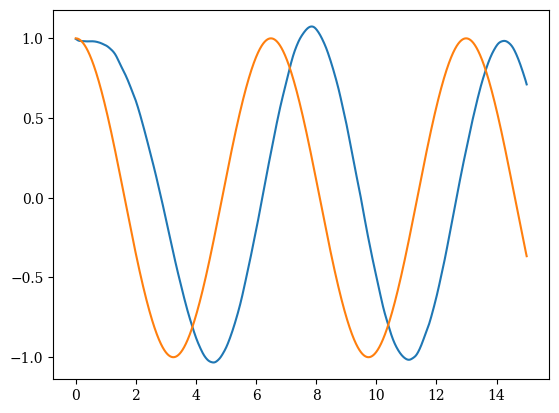

In [29]:
plt.plot(t_eval, PINN_x_solution_series_standard_underdamped[-1])
plt.plot(t_eval, numerical_underdamped_duffing[0])
plt.show()

In [30]:
w_sol = []
NN_TL_solution_LPM, perturbation_solution_LPM, _ = transfer.compute_perturbation_solution(w_list_transfer, zeta_list, epsilon_list, p_list, ic_list, forcing_list, H_dict, t_eval, training_log, all_p=True, comp_time=False, solver="LPM", w_sol = w_sol)
NN_TL_solution_LPM = NN_TL_solution_LPM.squeeze()

NameError: name 'zeta_list' is not defined

In [ ]:
w_final_list = []

for index in range(len(epsilon_list)):
    w_final_list.append(LPM.calculate_w_series(w_sol[0], epsilon_list[index], rwtol=1e-12))

w_final_list

[[1,
  np.float64(1.2249615417317095),
  np.float64(1.1954441094887285),
  np.float64(1.2039789574238693),
  np.float64(1.2007460172636413),
  np.float64(1.2021424509126646),
  np.float64(1.2014932278440398)]]

In [ ]:
w_final = w_final_list[0][-1]
t_eval_lpm, t_eval_standard = LPM.t_eval_lpm(t_eval, w_final)